# Information Retrieval

In [1]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm/" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

##  Indexing:

In [4]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
parser = ParserCACM.ParserCACM()
idx.indexation(cacm_txt, parser, stemmer, verbose=True)
N_docs = len(idx.getDocsID())
print("Successfully indexed %d documents" % N_docs)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.
Successfully indexed 3204 documents


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
This query has 28 relevant results
   i |found| precision | recall
    2|   1 | 0.500000  |0.035714
    4|   2 | 0.500000  |0.071429
   14|   3 | 0.214286  |0.107143
   15|   4 | 0.266667  |0.142857
   23|   5 | 0.217391  |0.178571
   25|   6 | 0.240000  |0.214286
   36|   7 | 0.194444  |0.250000
   43|   8 | 0.186047  |0.285714
   44|   9 | 0.204545  |0.321429
  127|  10 | 0.078740  |0.357143
  135|  11 | 0.081481

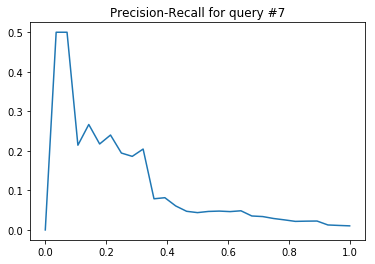

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
This query has 19 relevant results
   i |found| precision | recall
    2|   1 | 0.500000  |0.052632
    4|   2 | 0.500000  |0.105263
   22|   3 | 0.136364  |0.157895
   25|   4 | 0.160000  |0.210526
   26|   5 | 0.192308  |0.263158
   27|   6 | 0.222222  |0.315789
   34|   7 | 0.205882  |0.368421
   38|   8 | 0.210526  |0.421053
   41|   9 | 0.219512  |0.473684
  123|  10 | 0.081301  |0.526316
  126|  11 | 0.087302  |0.578947
  127|  12 | 0.094488  |0.631579
  137|  13 | 0.094891  |0.684211
  138|  14 | 0.101449  |0.736842
  139|  15 | 0.107914  |0.789474
  212|  16 | 0.075472  |0.842105
  213|  17 | 0.079812  |0.894737
  242|  18 | 0.074380  |0.947368
  382|  19 | 0.049738  |1.000000


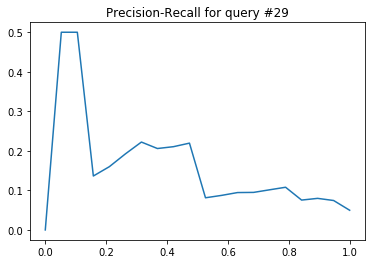

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
This query has 4 relevant results
   i |found| precision | recall
    3|   1 | 0.333333  |0.250000
    4|   2 | 0.500000  |0.500000
   37|   3 | 0.081081  |0.750000
  312|   4 | 0.012821  |1.000000


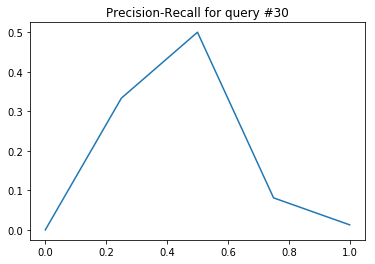

--------------------
Done.


In [5]:
binWeighter = modeles.BinaryWeighter(idx)
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


## Testing average precision:

In [6]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen =[9, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [9, 10, 14, 29] 

Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    1|   1 | 1.000000
    3|   2 | 0.666667
    8|   3 | 0.375000
   10|   4 | 0.400000
   12|   5 | 0.416667
   33|   6 | 0.181818
   62|   7 | 0.112903
  114|   8 | 0.070175
  169|   9 | 0.053254
Average precision: 0.364054
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
Evaluate the scores.
This query has 35 relevant resu

## Testing EvalIRModel:

In [7]:
print("\n###### Testing evaluation.EvalIRModel: ###### ")
queryChosen = np.random.randint(1, 64, size=10)
#queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [38 44 59  3 26  8 14 11 56 38] ...
Found queries
Calling eval()...
{('vectoriel_bw', 'averagePrecision'): (0.19078914857471294, 0.16158531936879822), ('vectoriel_tfidf', 'averagePrecision'): (0.25421049762565728, 0.16559802001058002)}
Done.


## Comparison of language models:

In [8]:
from sklearn.model_selection import train_test_split

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_train, q_test = train_test_split(queries)

# Train models, find best parameters.
unigram_params_grid = {'index':[idx], 'regularization':np.linspace(0,1, 20, endpoint=False)}

#c = dict_combinations(params_grid)
#print("comb: ",c)

best_unigram_params = {'index':idx, 'regularization':0.36842105263157893}
#best_unigram_params = evaluation.gridsearch(modeles.UnigramLanguage, unigram_params_grid, 
#                 q_train, evaluation.AveragePrecision, verbose=1)
print("Best unigram params:", best_unigram_params)

Searching for queries # [38 44 59  3 26  8 14 11 56 38] ...
Found all queries
Best unigram params: {'index': <indexation.Index object at 0x7f78244f8630>, 'regularization': 0.3684210526315789}


In [9]:
okapi_params_grid = {'index':[idx], 'k':np.linspace(1, 2, 10), 'b':np.linspace(0,2,10)}

best_okapi_params = {'index':idx, 'k': 1.1111111111111112, 'b': 0.44444444444444442}
#best_okapi_params = evaluation.gridsearch(modeles.Okapi, okapi_params_grid, 
#             q_train, evaluation.AveragePrecision, verbose=1)

print("Best okapi params:", best_okapi_params)

Best okapi params: {'index': <indexation.Index object at 0x7f78244f8630>, 'k': 1.1111111111111112, 'b': 0.4444444444444444}


### Execution on the test set:

In [10]:
print("best unigram params:", best_unigram_params)
print("best okapi params:", best_okapi_params)

irmodels = {'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)}

eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

best unigram params: {'index': <indexation.Index object at 0x7f78244f8630>, 'regularization': 0.3684210526315789}
best okapi params: {'index': <indexation.Index object at 0x7f78244f8630>, 'k': 1.1111111111111112, 'b': 0.4444444444444444}
IRModel: okapi
Measure: measure
(0.31792918023020861, 0.22842318366690459)
IRModel: unigram
Measure: measure
(0.23472680754812444, 0.17110056532188564)
{('unigram', 'measure'): (0.23472680754812444, 0.17110056532188564), ('okapi', 'measure'): (0.31792918023020861, 0.22842318366690459)}


In [11]:
print("\n###### Comparison of different models: ###### ")
queryChosen = np.random.randint(1, 64, size=5)
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter),
            'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Comparison of different models: ###### 
Searching for queries # [18 12 38 32  3 25 61 27 59 42 34  9 63 43  6 17 35 30 60  2] ...
Found queries
Calling eval()...
{('vectoriel_bw', 'averagePrecision'): (0.14577125299104834, 0.12544956712619476), ('okapi', 'averagePrecision'): (0.30850784415358301, 0.18401051756910761), ('vectoriel_tfidf', 'averagePrecision'): (0.23385479231112102, 0.16046801339477315), ('unigram', 'averagePrecision'): (0.30068116520950039, 0.1916573856833447)}
Done.


## PageRank

In [12]:
import graphes
pagerank = graphes.PageRank(idx, seeds=[1, 43], prevNeighbours=2)
np.set_printoptions(precision=2, thresholdb=5)
print("Scores:", pagerank.getScores(nIter=10, teleportProba=0.1))

21 nodes
Graph:
 [[ 0.    0.05  0.05 ...,  0.05  0.05  0.05]
 [ 0.09  0.    0.   ...,  0.    0.09  0.09]
 [ 0.25  0.    0.   ...,  0.25  0.    0.25]
 ..., 
 [ 0.25  0.    0.25 ...,  0.    0.    0.25]
 [ 0.07  0.07  0.   ...,  0.    0.    0.07]
 [ 0.08  0.08  0.08 ...,  0.08  0.08  0.  ]]
Nodes: [1, 642, 324, 196, 205, 398, 210, 214, 410, 1883, 91, 669, 100, 165, 164, 43, 3184, 53, 1273, 123, 1982]
Scores: {1: 0.047619047619047616, 642: 0.047619047619047616, 1883: 0.047619047619047616, 324: 0.047619047619047616, 165: 0.047619047619047616, 100: 0.04761904761904763, 3184: 0.047619047619047616, 43: 0.047619047619047616, 205: 0.047619047619047616, 398: 0.04761904761904763, 164: 0.04761904761904763, 210: 0.047619047619047616, 123: 0.047619047619047616, 53: 0.047619047619047616, 214: 0.047619047619047616, 1273: 0.047619047619047616, 196: 0.047619047619047616, 410: 0.047619047619047616, 91: 0.047619047619047616, 669: 0.047619047619047616, 1982: 0.047619047619047616}


In [23]:
np.set_printoptions(edgeitems=10)
g = pagerank.graph.toarray()
print(np.alltrue(g <= 1))
N = len(pagerank.nodes)
print("%d nodes" % N)
for i in range(N):
    if np.all(g[i] == 0):
        g[i] = np.ones(N)
    s = (g[i].sum())
    g[i] /= s
print("Graph:\n", g)


True
21 nodes
Graph:
 [[ 0.    0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05 ...,  0.05
   0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
 [ 0.09  0.    0.    0.09  0.09  0.09  0.09  0.09  0.    0.   ...,  0.09
   0.09  0.    0.09  0.    0.    0.    0.    0.09  0.09]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25 ...,  0.    0.
   0.    0.    0.    0.    0.    0.25  0.    0.25]
 [ 0.11  0.11  0.    0.    0.11  0.11  0.11  0.    0.11  0.   ...,  0.    0.
   0.11  0.    0.    0.11  0.    0.    0.11  0.  ]
 [ 0.07  0.07  0.    0.07  0.    0.07  0.07  0.07  0.07  0.   ...,  0.07
   0.07  0.    0.07  0.07  0.07  0.    0.    0.07  0.07]
 [ 0.08  0.08  0.    0.08  0.08  0.    0.08  0.08  0.08  0.   ...,  0.08
   0.08  0.    0.08  0.    0.08  0.    0.    0.08  0.08]
 [ 0.08  0.08  0.    0.08  0.08  0.08  0.    0.08  0.    0.   ...,  0.08
   0.08  0.    0.08  0.    0.08  0.    0.    0.08  0.08]
 [ 0.08  0.08  0.    0.    0.08  0.08  0.08  0.    0.    0.   ...,  0.08